In [2]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import skill_metrics as sm

使用 03-15 年的mask后的数据来进行后续的泰勒图的相关性计算

In [3]:
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/ordata"
file_in = "sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
ds_obs = xr.open_dataset(path_in + "/" + file_in)

model_set = {} # 存放不同模式结果

path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res"
file_in = "mask_mean_vr_03-15.nc"
model_set["vr"] = xr.open_dataset(path_in + "/" + file_in)

path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res"
file_in = "mask_mean_rcm_03-15.nc"
model_set["rcm"] = xr.open_dataset(path_in + "/" + file_in)


进行时间平均，绘制空间上的taylor图

In [4]:
months = ["4","5","6","7","8"]
model_types = ["vr", "rcm"]

model_stats = {} # 存放 VR RCM 的位置

for model_type in model_types:
    month_stats = {} # 存放逐月的统计量
    # add every month
    for month_ind in months:
        # count month mean
        months_obs_mean = ds_obs["tm"].loc[ds_obs.time.dt.month==int(month_ind)].mean(dim=["time"])
        months_vr_mean = model_set[model_type]["t2m"].loc[model_set[model_type].Time.dt.month==int(month_ind)].mean(dim=["Time"])
        # ND to 1D
        temp_obs = months_obs_mean.values.ravel()
        temp_vr = months_vr_mean.values.ravel()
        # remove NaN
        temp_obs = temp_obs[~np.isnan(temp_obs)]
        temp_vr = temp_vr[~np.isnan(temp_vr)]
        # count taylor stats
        # pred1 , refer
        # month_stats[month_ind] = sm.taylor_statistics(np.array(months_mod_mean).ravel(),np.array(months_obs_mean).ravel())
        # add
        month_stats[month_ind] = sm.taylor_statistics(temp_vr, temp_obs)
    # add all year
    # count year(4-8 months) mean
    months_obs_mean = ds_obs["tm"].mean(dim=["time"])
    months_vr_mean = model_set[model_type]["t2m"].mean(dim=["Time"])
    # ND to 1D
    temp_obs = months_obs_mean.values.ravel()
    temp_vr = months_vr_mean.values.ravel()
    # remove NaN
    temp_obs = temp_obs[~np.isnan(temp_obs)]
    temp_vr = temp_vr[~np.isnan(temp_vr)]
    # add
    month_stats['all'] = sm.taylor_statistics(temp_vr, temp_obs)    # add module set
    model_stats[model_type] = month_stats


In [5]:
model_stats['vr']['4']

{'ccoef': array([1.        , 0.97336382]),
 'crmsd': [0.0, 2.9168049599766093],
 'sdev': [7.435949, 9.604606307087634]}

进行标准化等数据预处理

In [6]:
year_select = ["2004","2005","2006","2007","2008"]
months = ["4","5","6","7","8","all"]
model_types = ["vr", "rcm"]
model_plot = {} # 存放不同模式的taylor plot的结果

# 将泰勒图诸要素整理到 model_plot 中，并接着绘图
for model_type in model_types:

    sdev  = []
    crmsd = []
    ccoef = []
    sdev_obs = []
    # append obs
    #----- normilized -----
    sdev.append(model_stats[model_type][month_ind]['sdev'][0]/model_stats[model_type][month_ind]['sdev'][0])
    crmsd.append(model_stats[model_type][month_ind]['crmsd'][0]/model_stats[model_type][month_ind]['sdev'][0])
    ccoef.append(model_stats[model_type][month_ind]['ccoef'][0])

    for month_ind in months:

        # statistics can be normalized
        # obs sdev=1 crmsd=0 ccoef=1
        # append 4-8 months
        #----- normilized -----
        sdev.append(model_stats[model_type][month_ind]['sdev'][1]/model_stats[model_type][month_ind]['sdev'][0])
        crmsd.append(model_stats[model_type][month_ind]['crmsd'][1]/model_stats[model_type][month_ind]['sdev'][0])
        ccoef.append(model_stats[model_type][month_ind]['ccoef'][1])

    # append all round year
    sdev  = np.array(sdev)
    crmsd = np.array(crmsd)
    ccoef = np.array(ccoef)

    # add to model plot
    model_plot[model_type] = {"sdev":sdev, "crmsd":crmsd, "ccoef":ccoef}

泰勒图绘制<br>
拆分为两部分，RCM和VR，使用overlay来绘制

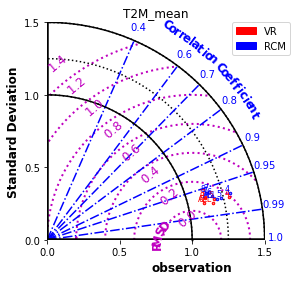

In [14]:
# >> taylor_diagram
# 不是多个模型对同一时段的模拟，绘制taylor图只是说明下相关性
# 逐年的固定某个月份 下面的 rmsd_select_year 在 months 中的范围大致是相同的
# label = ['Non-Dimensional Observation', 'M1']

label1 = {'VR': 'r', 'RCM': 'b'}
label2 = ["obs","4","5","6","7","8","ALL"]
lsCOR = np.concatenate((np.arange(0.4,1.0,0.2), [0.7,0.9, 0.95, 0.99, 1]))
# lsCOR = np.array([0.7,0.9, 0.95, 0.99, 1])

ax1 = sm.taylor_diagram(model_plot['vr']['sdev'],model_plot['vr']['crmsd'],model_plot['vr']['ccoef'], markerLabel = label2, 
tickRMS = np.arange(0,1.5,0.2), tickRMSangle = 130, 
colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
tickCOR = lsCOR,
tickSTD = [0,1,1.25,1.5], axismax = 1.5, 
showlabelsSTD = 'on',
rmslabelformat = ':.1f',
styleOBS = '-', 
colOBS = 'k',
markerobs = 'o', 
markerColor = 'r',
markerLabelColor = 'r',
markerSize = 5, 
alpha = 0.5, 
showlabelsCOR = 'on',
titleOBS = 'observation')

ax2 = sm.taylor_diagram(model_plot['rcm']['sdev'],model_plot['rcm']['crmsd'],model_plot['rcm']['ccoef'], markerLabel =label2,
markerColor = 'b',
markerLabelColor = 'b', 
titleOBS = 'observation',
markerSize = 5,
alpha = 0.5, 
overlay='on',
checkStats = 'on')


plt.title("T2M_mean")

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='VR')
blue_patch = mpatches.Patch(color='blue', label='RCM')
plt.legend(handles=[red_patch, blue_patch], loc=[0.85,0.85])

# legend_elements = [color='b', lw=4, label='Line'),
# Line2D([0], [0], marker='o', color='w', label='Scatter',
#                           markerfacecolor='g', markersize=15),
#                    Patch(facecolor='orange', edgecolor='r',
#                          label='Color Patch')]
# plt.legend(label1, loc='upper right')

pic_output_path = "./output_pic/"
plt.savefig(pic_output_path + "t2m_mean_taylor_normalized_2003-2015_space",dpi=300,facecolor = "white")
# del(ax)

<Figure size 432x288 with 0 Axes>